# Setup

In this notebook, we conduct a Difference-in-Differences (DiD) analysis to examine the impact of the April 1992 minimum wage increase in New Jersey on employment levels in the fast-food industry. We utilize data from fast-food restaurants in New Jersey (treatment group) and Pennsylvania (control group) to assess how the policy change affected full-time equivalent (FTE) employment.

The analysis follows the methodology used by Card and Krueger (1994) in their seminal study on the effects of minimum wage increases on employment. We will build several Ordinary Least Squares (OLS) regression models, gradually incorporating control variables to improve the robustness of our findings. Additionally, we will visualize the results to better understand the policy's impact.

We begin by setting up our environment and importing the necessary libraries.

In [ ]:
# Mount Google Drive to access data files (specific to Google Colab)
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Change the working directory to where the data file is located
%cd /content/drive/MyDrive/Statistics and Econometrics/Econometrics/Difference-in-Differences


/content/drive/MyDrive/Statistics and Econometrics/Econometrics/Difference-in-Differences


In [ ]:
# Import essential libraries
import pandas as pd                  # For data manipulation and analysis
import numpy as np                   # For numerical computations
import statsmodels.api as sm         # For statistical modeling and regression analysis
import matplotlib.pyplot as plt      # For plotting graphs
from sklearn.impute import SimpleImputer  # For handling missing data

We load the dataset `njmin3.csv` into a pandas DataFrame and take a quick look at the first few rows.

In [ ]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('njmin3.csv')

# Display the first five rows of the dataset
df.head()

,NJ,POST_APRIL92,NJ_POST_APRIL92,fte,bk,kfc,roys,wendys,co_owned,centralj,southj,pa1,pa2,demp
0,1,0,0,15.00,1,0,0,0,0,1,0,0,0,12.00
1,1,0,0,15.00,1,0,0,0,0,1,0,0,0,6.50
2,1,0,0,24.00,0,0,1,0,0,1,0,0,0,-1.00
3,1,0,0,19.25,0,0,1,0,1,0,0,0,0,2.25
4,1,0,0,21.50,1,0,0,0,0,0,0,0,0,13.00


# Data Analysis and Processing

We generate summary statistics to understand the central tendency and dispersion of the variables.

In [ ]:
# Generate descriptive statistics for numerical columns
df.describe()

,NJ,POST_APRIL92,NJ_POST_APRIL92,fte,bk,kfc,roys,wendys,co_owned,centralj,southj,pa1,pa2,demp
count,820.000000,820.000000,820.000000,794.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,768.000000
mean,0.807317,0.500000,0.403659,21.026511,0.417073,0.195122,0.241463,0.146341,0.343902,0.153659,0.226829,0.087805,0.104878,-0.070443
std,0.394647,0.500305,0.490930,9.422746,0.493376,0.396536,0.428232,0.353664,0.475299,0.360841,0.419037,0.283184,0.306583,9.016441
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-41.500000
25%,1.000000,0.000000,0.000000,14.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000
50%,1.000000,0.500000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,25.500000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000
max,1.000000,1.000000,1.000000,85.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,34.000000


We check for missing values in the dataset to identify any data cleaning that may be necessary.

In [ ]:
# Check the total number of missing values in each column
df.isnull().sum()

# Check if any column contains missing values
df.isnull().any()

,0
NJ,False
POST_APRIL92,False
NJ_POST_APRIL92,False
fte,True
bk,False
kfc,False
roys,False
wendys,False
co_owned,False
centralj,False


We replace missing values in the `fte` (full-time equivalent employment) and `demp` (change in employment) columns with the mean of the respective columns.

**Imputation**: The process of replacing missing data with substituted values to allow for complete data analysis.

In [ ]:
# Initialize the SimpleImputer to replace missing values with the mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Apply the imputer to the 'fte' and 'demp' columns
df[['fte', 'demp']] = imputer.fit_transform(df[['fte', 'demp']])

# Recheck for missing values after imputation
df.isnull().sum()

,0
NJ,0
POST_APRIL92,0
NJ_POST_APRIL92,0
fte,0
bk,0
kfc,0
roys,0
wendys,0
co_owned,0
centralj,0


# Model 1: Basic Difference-in-Differences Estimation

We set up our dependent variable y and independent variables X for the first regression model.

In [ ]:
# Define the independent variables for the model
X = df[['NJ', 'POST_APRIL92', 'NJ_POST_APRIL92']]

# Define the dependent variable as full-time equivalent employment
y = df['fte']

# Preview the independent variables
X.head()

,NJ,POST_APRIL92,NJ_POST_APRIL92
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


Explanation of Key Concepts:

* **Difference-in-Differences (DiD)**: A statistical technique used to estimate causal relationships by comparing the changes in outcomes over time between a treatment group and a control group.

* **Treatment Group**: The group that is exposed to the treatment or policy change (New Jersey in this case).

* **Control Group**: The group that is not exposed to the treatment (Pennsylvania in this case).

We add a constant term to the independent variables to include an intercept in our regression model.

In [ ]:
# Add a constant term to the independent variables
X1 = sm.add_constant(X)

# Preview the updated independent variables
X1.head()

,const,NJ,POST_APRIL92,NJ_POST_APRIL92
0,1.0,1,0,0
1,1.0,1,0,0
2,1.0,1,0,0
3,1.0,1,0,0
4,1.0,1,0,0


We use Ordinary Least Squares (OLS) regression to estimate the model parameters.

In [ ]:
# Fit the OLS regression model
model1 = sm.OLS(y, X1).fit()

# Print the summary of the regression results with descriptive variable names
print(model1.summary(
    yname="FTE",
    xname=['Intercept', 'New Jersey', 'After April 1992', 'New Jersey and After April 1992'],
))

                            OLS Regression Results                            
Dep. Variable:                    FTE   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.974
Date:                Wed, 30 Oct 2024   Prob (F-statistic):              0.116
Time:                        11:38:37   Log-Likelihood:                -2986.2
No. Observations:                 820   AIC:                             5980.
Df Residuals:                     816   BIC:                             5999.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

**Explanation of Key Concepts:**
* **OLS Regression**: A method for estimating the unknown parameters in a linear regression model by minimizing the sum of squared residuals.

* **Coefficient Interpretation:**

  * **Intercept**: Average FTE employment in the control group before the policy change.
  * **New Jersey**: Difference in average FTE between New Jersey and Pennsylvania before the policy change.
  * **After April 1992**: Change in average FTE in Pennsylvania after the policy change.
  * **New Jersey and After April 1992**: The DiD estimator capturing the policy's impact.

## Data Visualization

We visualize the estimated effects to better understand the impact of the minimum wage increase.

We extract the coefficients from the regression model to compute predicted FTE values.

In [ ]:
# Extracting the coeffients
intercept, nj_coef, post_april92_coef, nj_post_april92_coef = model1.params

Using the coefficients, we calculate the predicted FTE employment for each group.

In [ ]:
# Predicted FTE for Pennsylvania before and after the policy change
pre_pa = intercept
post_pa = intercept + post_april92_coef

# Predicted FTE for New Jersey before and after the policy change
pre_nj = intercept + nj_coef
post_nj = intercept + nj_coef + post_april92_coef + nj_post_april92_coef

# Counterfactual FTE for New Jersey if the policy had no effect
counterfactual = intercept + nj_coef + post_april92_coef


**Counterfactual**: An estimate of what would have happened to the treatment group if the treatment had not occurred.

We plot the observed and counterfactual FTE employment to visualize the impact.

[]

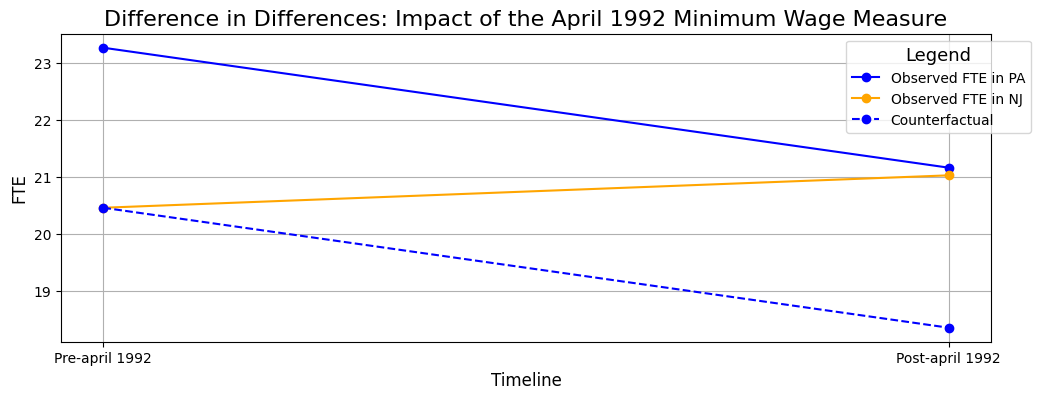

In [ ]:
# Set up the plot size
plt.figure(figsize=(12, 4))

# Define the timeline labels
time = ['Pre-April 1992', 'Post-April 1992']

# Plot observed FTE for Pennsylvania
plt.plot(time,
         [pre_pa, post_pa],
         marker='o',
         linestyle='-',
         color='blue',
         label='Observed FTE in PA')

# Plot observed FTE for New Jersey
plt.plot(time,
         [pre_nj, post_nj],
         marker='o',
         linestyle='-',
         color='orange',
         label='Observed FTE in NJ')

# Plot counterfactual FTE for New Jersey
plt.plot(time,
         [pre_nj, counterfactual],
         marker='o',
         linestyle='--',
         color='green',
         label='Counterfactual FTE in NJ')

# Customize the plot
plt.title("Difference-in-Differences: Impact of the April 1992 Minimum Wage Increase",
          fontsize=16)
plt.xlabel("Timeline", fontsize=12)
plt.ylabel("Full-Time Equivalent Employment (FTE)", fontsize=12)
plt.legend(loc='upper right',
           title="Legend",
           fontsize=10,
           frameon=True,
           title_fontsize=13)
plt.grid(True)

# Display the plot
plt.show()


# Model 2: Adding Control Variables

We extend our model by including additional control variables to account for other factors that may influence employment.

We inspect the available columns in the dataset to identify suitable control variables.

In [ ]:
# Display all column names in the DataFrame
df.columns

Index(['NJ', 'POST_APRIL92', 'NJ_POST_APRIL92', 'fte', 'bk', 'kfc', 'roys',
       'wendys', 'co_owned', 'centralj', 'southj', 'pa1', 'pa2', 'demp'],
      dtype='object')

Suppose we include variables such as:

* `bk`: Indicator for Burger King restaurants
* `kfc`: Indicator for KFC restaurants
* `wendys`: Indicator for Wendy's restaurants

We include the restaurant chain indicators as control variables.

In [ ]:
# Define the new set of independent variables including control variables
X2 = df[['NJ', 'POST_APRIL92', 'NJ_POST_APRIL92', 'bk', 'kfc', 'wendys']]

# Preview the new independent variables
X2.head()

,NJ,POST_APRIL92,NJ_POST_APRIL92,bk,kfc,wendys
0,1,0,0,1,0,0
1,1,0,0,1,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,1,0,0


We add a constant term to include an intercept in the new regression model.

In [ ]:
# Add a constant term to the independent variables
X2 = sm.add_constant(X2)

**Control Variables**: Variables that are held constant or whose impact is removed to better isolate the effect of the independent variable of interest.

In [ ]:
# Fit the OLS regression model with control variables
model2 = sm.OLS(y, X2).fit()

# Print the summary of the regression results with descriptive variable names
print(model2.summary(
    yname="FTE",
    xname=['Intercept', 'New Jersey', 'After April 1992',
           'New Jersey and After April 1992',
           'Burger King', 'KFC', 'Wendy\'s'],
))

                            OLS Regression Results                            
Dep. Variable:                    FTE   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     31.95
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           1.30e-34
Time:                        12:21:29   Log-Likelihood:                -2902.4
No. Observations:                 820   AIC:                             5819.
Df Residuals:                     813   BIC:                             5852.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

# Model 3: Including Additional Control Variables

We further enhance our model by adding more control variables related to ownership and location.

We include additional variables such as:

* `co_owned`: Indicator for company-owned restaurants
* `centralj`, `southj`: Indicators for regions within New Jersey
* `pa1`, `pa2`: Indicators for regions within Pennsylvania

In [ ]:
# Define the new set of independent variables including more control variables
X3 = df[['NJ', 'POST_APRIL92', 'NJ_POST_APRIL92', 'bk', 'kfc',
         'wendys', 'co_owned', 'centralj', 'southj', 'pa1', 'pa2']]

# Preview the new independent variables
X3.head()

# Add a constant term to the independent variables
X3 = sm.add_constant(X3)

We fit the regression model with the expanded set of control variables.

**Robustness Checks**: Adding control variables and re-estimating the model to ensure that the results are not sensitive to model specification.


In [ ]:
# Fit the OLS regression model with additional control variables
model3 = sm.OLS(y, X3).fit()

# Print the summary of the regression results
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    fte   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     22.43
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           2.66e-37
Time:                        12:30:53   Log-Likelihood:                -2888.8
No. Observations:                 820   AIC:                             5800.
Df Residuals:                     809   BIC:                             5851.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              17.6833      0.734     

# Conclusion
Our analysis investigates the impact of the April 1992 minimum wage increase in New Jersey on employment in the fast-food industry using a Difference-in-Differences approach. The initial model suggests that the policy had an effect on full-time equivalent employment in New Jersey compared to Pennsylvania.

By incorporating additional control variables related to restaurant chains, ownership, and regional indicators, we aim to control for other factors that could influence employment. The consistency of the policy impact across different model specifications strengthens the validity of our findings.

Overall, the results indicate that the minimum wage increase led to a reduction in employment in New Jersey's fast-food industry. This has important implications for policymakers considering the employment effects of minimum wage policies.